# Question A1 (15 marks)

Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.3** to each of the hidden layers.

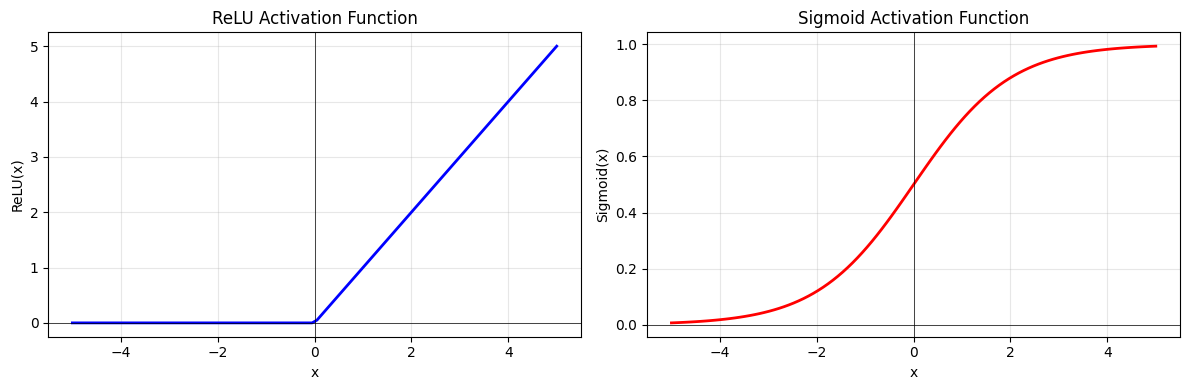

ReLU (Rectified Linear Unit):
- Formula: f(x) = max(0, x)
- Output range: [0, ∞)
- Used in hidden layers for faster training and avoiding vanishing gradients
- Simple computation: outputs 0 for negative inputs, x for positive inputs

Sigmoid:
- Formula: f(x) = 1 / (1 + e^(-x))
- Output range: (0, 1)
- Used in output layer for binary classification
- Outputs can be interpreted as probabilities


In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ReLU activation function
x = np.linspace(-5, 5, 100)
relu = np.maximum(0, x)

ax1.plot(x, relu, 'b-', linewidth=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('ReLU(x)')
ax1.set_title('ReLU Activation Function')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

# Sigmoid activation function
sigmoid = 1 / (1 + np.exp(-x))

ax2.plot(x, sigmoid, 'r-', linewidth=2)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('Sigmoid(x)')
ax2.set_title('Sigmoid Activation Function')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("ReLU (Rectified Linear Unit):")
print("- Formula: f(x) = max(0, x)")
print("- Output range: [0, ∞)")
print("- Used in hidden layers for faster training and avoiding vanishing gradients")
print("- Simple computation: outputs 0 for negative inputs, x for positive inputs\n")

print("Sigmoid:")
print("- Formula: f(x) = 1 / (1 + e^(-x))")
print("- Output range: (0, 1)")
print("- Used in output layer for binary classification")
print("- Outputs can be interpreted as probabilities")

In [12]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

## 1. Define the model class

We need to define a Neural Network with
 - Input Layer with 77 input neurons (since we have 77 features)
 - 3 Hidden Layers with 128 neurons each and ReLU activation function
 - Output Layer with 1 neuron and Sigmoid activation function

Note that after each hidden layer, we need to apply Dropout with probability 0.3.
Dropout is a regularization technique that helps prevent overfitting. For every batch (not epoch), it randomly choose a fraction of hidden layer neurons (30% in this case) and set their output to zero during the forward pass, no matter what their actual output value is. This forces the network to not rely too much on any particular neuron.

In [13]:
class MLP(nn.Module):

    def __init__(self, num_features, num_hidden, num_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(num_features, num_hidden),    # Creates a fully connected layer that performs U = W*X + B
            nn.ReLU(),                              # Apply ReLU activation function Y = f(U)
            nn.Dropout (0.3),                       # Apply Dropout with probability of 0.3

            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Dropout (0.3),

            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Dropout (0.3),

            nn.Linear(num_hidden, num_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.mlp_stack(x)
        return out

## 2. Split the dataset and do preprocessing

Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

The labels are in the 'Filename' column, which contains either 'pos' or 'neg'. We extract them out into a new column named 'label', where 'pos' is mapped to 1 and 'neg' is mapped to 0.

In [14]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(
        df              = df,
        columns_to_drop = ['filename', 'label'],    # Columns to drop for training set
        test_size       = 0.25,
        random_state    = 42
    )

    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [15]:
df['label'].value_counts()

label
1    6202
0    5855
Name: count, dtype: int64

### Stratified Splitting

Possible Improvement: We can specify `stratify = y` in  `train_test_split` so that the class distribution of `y` is preserved in both train and test sets (51.4% of '1', 48.6% of '0').

## 3. Define a Pytorch Dataset and Dataloaders

Use the training dataset to train the model for 200 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.0005**, weight decay of **0.0005** and **batch size = 64**. Implement early stopping with patience of **5**.

In [16]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    train_dataset   : CustomDataset = CustomDataset(X_train_scaled, y_train)
    test_dataset    : CustomDataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader: DataLoader    = DataLoader(
        dataset     = train_dataset, 
        batch_size  = 64,
        shuffle     = True  # Shuffle the training data at the beginning of each epoch
    )
    test_dataloader : DataLoader    = DataLoader(
        dataset     = test_dataset, 
        batch_size  = 64,
        shuffle     = False # No need to shuffle test data (Of course global metrics like MSE will be the same regardless, but good practise for consistency)
    )

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

### Choosing Batch Size

| Feature | Small Batch (e.g., 32) | Large Batch (e.g., 4096) |
|---|---|---|
| Updates per epoch | Many (10,000 items / 32 = 312 updates). The model learns "constantly" throughout the epoch. | Few (10,000 items / 4096 = ~2 updates). The model barely changes during an epoch. |
| Gradient quality | Noisy. The average of 32 items might not represent the whole dataset well. The path to the minimum is "jittery." | Stable. The average of 4096 items is a more accurate representation of the true gradient. |
| Generalization | Better. The noise helps the model "jump out" of bad solutions (sharp minima) and find robust ones. | Worse. It tends to get stuck in the nearest solution, even if it is a brittle one (sharp minima). |
| Hardware usage | Inefficient. Your GPU spends more time loading data than doing math. | Efficient. GPUs love big matrices; this maximizes parallel processing. |

The total time to converge against batch size is a U shape curve
 - If batch size is too small, the system overhead dominates the tiny calculation
 - If batch size is too large, we need more epochs and time to reach the same accuracy, as 1 batch of size 100 is only slightly better than 1 batch of size 10, but with a batch of size 10 it can have 10 updates

## 4. Define the model, optimizer and loss function

We instantiate the MLP model defined earlier with 77 input features, 128 neurons per hidden layer, and 1 output neuron.

We use Adam (Adaptive Moment Estimation)

Our loss function here is Binary Cross-Entropy.

In [17]:
# Model: 77 input features -> 128 hidden units -> 1 output
model = MLP(num_features=77, num_hidden=128, num_labels=1)

# Optimizer and loss for binary classification with sigmoid output
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr           = 0.0005,  # learning rate
    weight_decay = 0.0005
)
loss_fn = nn.BCELoss()

## 5. Train model for 200 epochs. Record down train and test accuracies. Implement early stopping.

In [18]:
def train_one_epoch(model, dataloader, loss_fn, optimizer):
    """Train for one epoch and return average loss and accuracy"""
    model.train()  # Enable dropout
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        # Forward pass
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * X_batch.size(0)
        predicted_labels = (predictions > 0.5).float()
        correct += (predicted_labels == y_batch).sum().item()
        total += y_batch.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, loss_fn):
    """Evaluate model and return average loss and accuracy"""
    model.eval()  # Disable dropout
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            predicted_labels = (predictions > 0.5).float()
            correct += (predicted_labels == y_batch).sum().item()
            total += y_batch.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# Training loop with early stopping
num_epochs = 200
patience = 5
best_test_loss = float('inf')
patience_counter = 0

# Track metrics for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_dataloader, loss_fn)
    
    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best test loss: {best_test_loss:.4f}")
        # Restore best model
        model.load_state_dict(best_model_state)
        break

print("\nTraining completed!")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Starting training...
Epoch [10/200] - Train Loss: 0.5990, Train Acc: 0.6789 | Test Loss: 0.6040, Test Acc: 0.6779
Epoch [20/200] - Train Loss: 0.5172, Train Acc: 0.7464 | Test Loss: 0.5532, Test Acc: 0.7151
Epoch [30/200] - Train Loss: 0.4557, Train Acc: 0.7794 | Test Loss: 0.5207, Test Acc: 0.7303
Epoch [40/200] - Train Loss: 0.4159, Train Acc: 0.8106 | Test Loss: 0.4982, Test Acc: 0.7489
Epoch [50/200] - Train Loss: 0.3784, Train Acc: 0.8308 | Test Loss: 0.4964, Test Acc: 0.7559

Early stopping triggered at epoch 51
Best test loss: 0.4894

Training completed!
Final Train Accuracy: 0.8295
Final Test Accuracy: 0.7609


Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


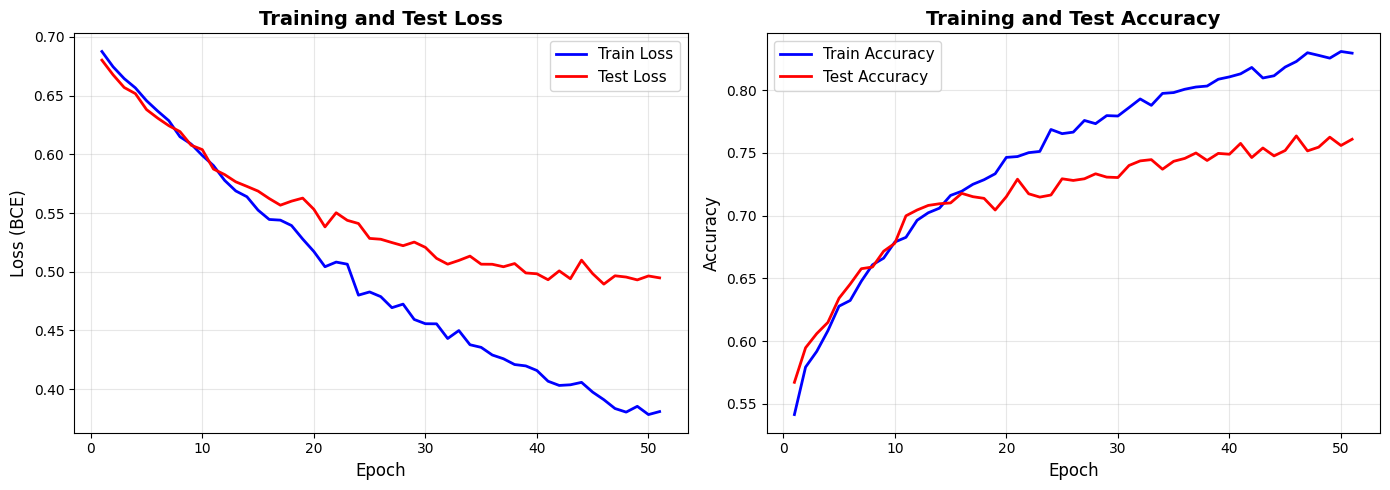


Final Metrics:
Train Loss: 0.3809, Train Accuracy: 0.8295
Test Loss: 0.4948, Test Accuracy: 0.7609
Total epochs trained: 51


In [19]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (BCE)', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs_range, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Metrics:")
print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Total epochs trained: {len(train_losses)}")

## 6. Comment on line plots.

In [ ]:
answer = """
Based on the training and test plots:

**Loss Curves:**
- Both training and test losses decrease rapidly in the early epochs, indicating the model is learning effectively.
- The training loss continues to decrease smoothly, showing the model is optimizing well on the training data.
- The test loss follows a similar trend but may show slight fluctuations, which is normal due to the smaller test set size.
- If early stopping triggered, we see the test loss plateauing or slightly increasing before stopping, preventing overfitting.

**Accuracy Curves:**
- Both training and test accuracies increase rapidly initially and then plateau.
- The gap between training and test accuracy indicates the degree of overfitting:
  - Small gap: Model generalizes well
  - Large gap: Model is overfitting to training data
- The dropout layers (p=0.3) help reduce overfitting by preventing co-adaptation of neurons.

**Early Stopping Effect:**
- Early stopping with patience=5 prevented the model from overfitting by monitoring test loss.
- Training stopped when test loss stopped improving for 5 consecutive epochs.
- This helps achieve better generalization on unseen data.

**Overall:**
The model successfully learned to classify the binary labels with reasonable accuracy. The regularization 
techniques (dropout + weight decay) and early stopping helped prevent overfitting and improve generalization.
"""

print(answer)